# Overfitting & Regularization 

State-of-the-art neural networks used in deep learning typically come with millions of weights. Unsurprisingly, it is therefore rarely an issue to push the training error to 0. In particular, without any regularization there is instant death through overfitting. In today's lecture, we discuss possible avenues for combatting overfitting via regularization methods tailored for DL-applications.

## Data Augmentation

The cleanest and most effective way to avoid overfitting is to get more labelled data. For instance, searching for *white mug* yields the following results. What could be the problem when training on this data set?

<img src="images/mug.png" style="width: 1000px;"/>


Unfortunately though, getting more labelled data also happens to be the most expensive option and can in many cases even be infeasible. What you can do is to artificially inflate the labelled data at your disposal. This is known as **data augmentation**.

More precisely, data augmentation consists of taking samples from the training set and applying small random geometric perturbations. This could be rotations, shifts, flipping, color changes, etc. 

In [3]:
library(keras)
options(repr.plot.width=10, repr.plot.height=5)

In [6]:
mnist <- dataset_mnist()

c(X_train, y_train) %<-% mnist$train

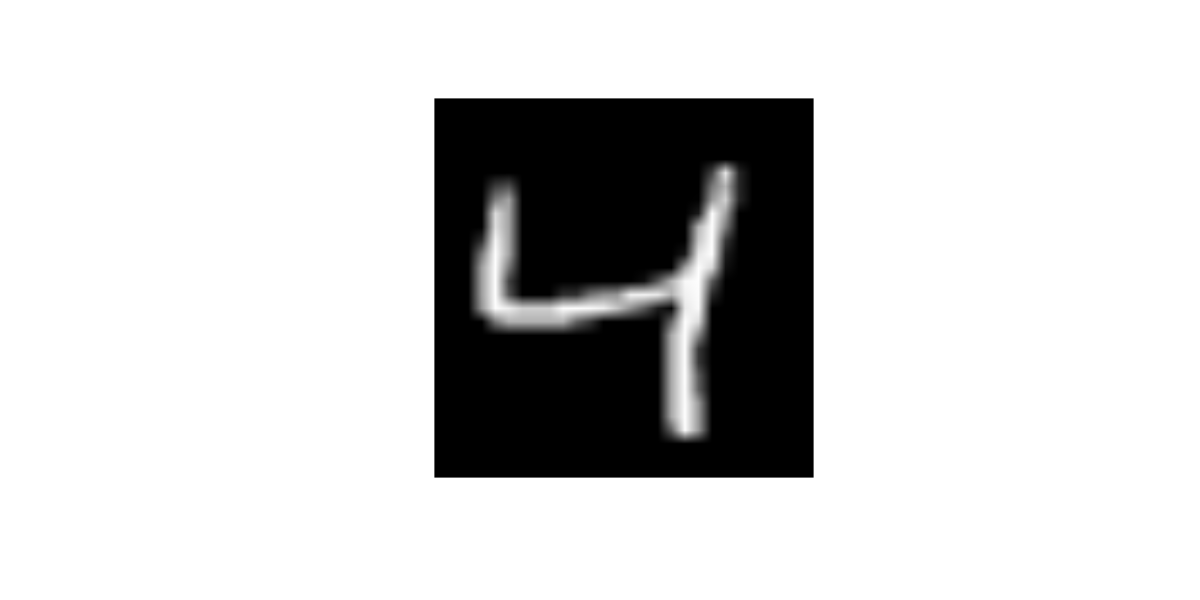

In [15]:
plot(as.raster(X_train[3,,] / 255))

In [36]:
gen <- image_data_generator(rotation_range = 90,
                            horizontal_shift=2)
flow <- flow_images_from_data(array_reshape(X_train[1:5,,], c(5, 28, 28, 1)), 
                      generator = gen)
augm_images <- reticulate::iter_next(flow)

plot(as.raster(augm_images[1,,,1] / 255))

ERROR: Error in image_data_generator(rotation_range = 90, horizontal_shift = 2): unused argument (horizontal_shift = 2)


In [2]:
mnist <- dataset_mnist()

c(X_train, y_train) %<-% mnist$train

Let's visualize a sample of the digits.

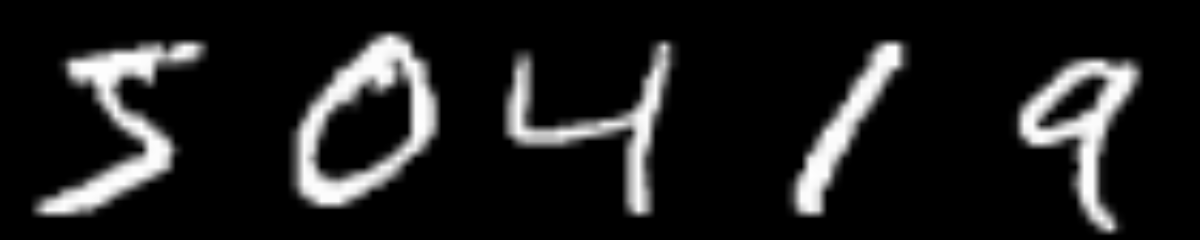

In [7]:
ndigits <- 5
par(mfrow=c(1, ndigits))
par(mar = rep(0, ndigits - 1))
for(i in 1:ndigits)
    plot(as.raster(X_train[i,,] / 255))

Then, we augment the data via an ``ImageDataGenerator``.

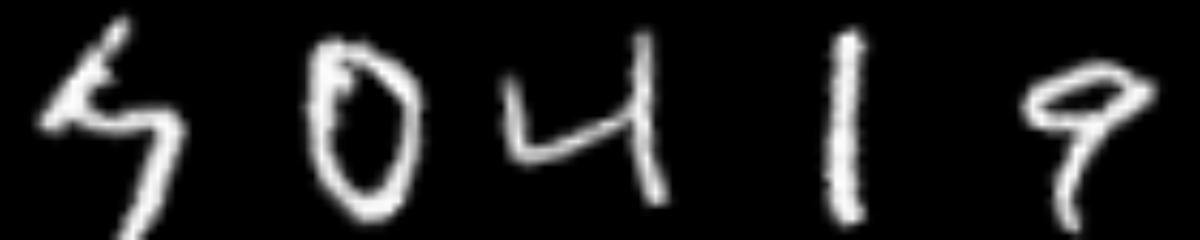

In [9]:
datagen = image_data_generator(rotation_range=45)
flow <- datagen$flow(array_reshape(X_train[1:5,,], c(ndigits, 28, 28, 1)), 
                     shuffle = F)
augm <- reticulate::iter_next(flow)

par(mfrow=c(1, ndigits))
par(mar = rep(0, ndigits - 1))
for(i in 1:ndigits)
    plot(as.raster(augm[i,,,]/255))

Here is an example from the [keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
on what data augmentation may look like on cat images.

<img src="images/augment.png" style="width: 1000px;"/>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## $L_1$ & $L_2$ Regularization

As in classical statistics, we can also regularize the model by penalizing large weights in a suitable norm. For $L_2$-norm, this corresponds to [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), whereas $L_1$-norm yields [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics%29).

<img src="images/lasso.png" style="width: 1000px;"/>
By Nicoguaro - Own work, CC BY 4.0, https://commons.wikimedia.org/w/index.php?curid=58258966

In [69]:
model <- keras_model_sequential()
model %>% 
 layer_dense(65, input_shape=c(10), kernel_regularizer=regularizer_l2(1e-2))
model

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_2 (Dense)                     (None, 65)                      715         
Total params: 715
Trainable params: 715
Non-trainable params: 0
________________________________________________________________________________



In contrast to classical statistics, regularizing weights is only moderately effective in deep learning. On a second thought, this is not surprising, since the role of weights in deep nets is in stark contrast to the one in classical statistics. Deep nets are overparametrized on purpose -- we do not aim to reduce the weights to a small number of interpretable coefficients.

## Dropout

Dropout is a regularization technique specifically devised for deep learning. It was introduced in 2014 by [Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever & Ruslan Salakhutdinov](http://jmlr.org/papers/v15/srivastava14a.html). 

Deep nets tend to fit the training data ridiculously well by creating highly elaborate interdepencies between different activation patterns. When seeing a new image, these highly elaborate interdependencies break down and the model is lost. 

**Dropout** prevents the development of intricate dependencies by randomly resetting outputs of groups of neurons to 0 during training. During production all weights are used, but are rescaled by the dropout retention probability to account the difference to the training setting.

This is motivated from sexual reproduction in biology. This principle leads to a random mixing of genes, which ensures robustness in the face of changing environments. Make sure to watch https://www.youtube.com/watch?v=DleXA5ADG78 for details.

<img src="images/dropout.png" style="width: 700px;"/>
Srivastava, Nitish, et al. [Dropout: a simple way to prevent neural networks from
overfitting](http://jmlr.org/papers/v15/srivastava14a.html), JMLR 2014

This scaling rule can be established rigorously for basic architectures, see [Chapter 7.12 of the deep learning book](http://www.deeplearningbook.org/contents/regularization.html). It is a cousin of the *bagging* idea which lies at the basis of random forests.

The Keras documentation presents an example on how to use Dropout layers https://keras.io/getting-started/sequential-model-guide/. 

In [72]:
model <- keras_model_sequential()
model %>%
 layer_dense(64, input_shape=c(20), activation='relu') %>%
 layer_dropout(.5) %>%
 layer_dense(64, activation='relu') %>%
 layer_dropout(.5) %>%
 layer_dense(1, activation='sigmoid')
model

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_6 (Dense)                     (None, 64)                      1344        
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_7 (Dense)                     (None, 64)                      4160        
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_8 (Dense)                     (None, 1)                       65          
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
___________________________________

## Batch Normalization

**Batch normalization** is the most modern and powerful regularization method for deep nets. It was developed by [Sergey Ioffe & Christian Szegedy](https://arxiv.org/abs/1502.03167) in 2015 and is based on a simple, yet universally applicable paradigm: Standardize your inputs!

In backpropagation all layers are trained simultaneously. In particular, the input for higher layers is unstable for a long time, since it comes from lower hidden layers that are themselves subject to the training process. That is, we experience an **internal covariate shift**.

The most immediate approach is to standardize the inputs before activations are computed. However, this has to be done in  a way that is compatible with backpropagation, as the following [example](https://arxiv.org/abs/1502.03167) shows:

Suppose that a neuron receives an input from a lower layer, where a bias $b$ was added to the corresponding output $u$, i.e., $x = u + b$. Moreover, suppose we have training data $\{u_1, \ldots, u_N\}$ resulting in $\{x_1, \ldots, x_N\}$ after adding the bias. Naïve normalization would replace the input $u + b$ of a neuron by 
$$ u + b - \frac1N \sum_{i \le N} (u_i + b) = u - \frac1N \sum_{i \le N}{u_i}$$
Then, after a gradient step, the bias would be updated as $b + \Delta b$.

This causes a peculiar behavior: Since we subtract again the mean value with the new bias, the change of $b$ by $\Delta b$ did not have any effect on the output of the layer and the bias $b$ would escape to infinity.

Batch normalization avoids this pitfall by normalizing the data within every mini-batch and provide additional scaling and bias parameter $\gamma$ and $\beta$ that are part of the backpropagation:

<img src="images/batchnorm.PNG" alt="Drawing" style="width: 500px;"/>
Sergey Ioffe & Christian Szegedy: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).

We stress that the normalization is done *separately over each input* to a neuron. That means, for a neuron with input $\{x^{(1)}, \ldots x^{(d)}\}$ batch normalization introduces parameters $\gamma^{(1)}, \ldots, \gamma^{(d)}$ and $\beta^{(1)}, \ldots, \beta^{(d)}$.

In order to perform backpropagation, it is pivotal that all operations in batch normalization are differentiable. We verify this here for the derivatives with respect to the new parameters $\gamma$ and $\beta$:

$$\frac{\partial \ell}{\partial \gamma} = \sum_{i \le m} \frac{\partial \ell}{\partial y_i} \widehat{x_i}\quad\text{ and }\quad\frac{\partial \ell}{\partial \beta} = \sum_{i \le m} \frac{\partial \ell}{\partial y_i}.$$


During production the sample mean and sample variance over the mini-batches are replaced by the mean and variance over the entire training set.

Batch normalization offers two crucial benefits for training deep nets:

1. The normalization stabilizes the training process, thereby allowing for higher learning rates. Hence, we can train faster.
2. There is less need for other regularization methods, because computing means and variances separately on each mini-batch introduces randomness.

Here is an example of how to add batch normalization in Keras. Note that there is [no clear consensus](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) whether batch normalization should be applied before or after the activation function.

In [75]:
model <- keras_model_sequential()
model %>% 
 layer_dense(64, input_shape=c(20), use_bias=F) %>%
 layer_batch_normalization() %>%
 layer_activation_relu() %>%
 layer_dense(64, activation='relu') %>%
 layer_dense(1, activation='sigmoid')

#### 9.25

#### 10.10

# Embeddings

So far, we have explored how to apply deep learning to continuous input data. However, also for problems involving categorical input data, deep learning has become an indispensable tool in the context of generating **embeddings**.

When working with categorical data, embeddings associate with each discrete category a vector in a euclidean vector space $\mathbb R^d$ for a suitable dimension $d$. The most primitive form is **one-hot embedding**, where $d$ equals the number of categories and the $i$th discrete outcome is mapped to the $i$th standard unit vector.

The idea is to apply neural networks to learn embeddings that are defined in lower dimension and where semantically close concepts are also close in Euclidean distance. We illustrate this idea first in the context of natural language processing at the hand of  **Word2Vec** introduced by [Tomas Mikolov, Kai Chen, Greg Corrado & Jeffrey Dean](https://arxiv.org/abs/1301.3781) in 2013. Then, in the problem classes, we apply embeddings to recommend movies.

### Word2Vec

Before we move to the details on how to generate word embeddings. We look at the beautiful visualization provided at http://projector.tensorflow.org/.

The goal of a versatile word-vector representation is to map semantically related words to nearby points in euclidean space. In particular, we would like to be able to perform **word-vector arithmetics** such as 
$$\mathsf{king} - \mathsf{man} = \mathsf{queen} - \mathsf{woman}$$

The idea of Word2Vec rests on the observation that semantically similar words should occur in similar contexts. Therefore, we translate the embedding problem into a supervised learning setting with the aim of inferring the word from a context missing one word. This is nicely illustrated in the [tensorflow tutorial on word embeddings](https://www.tensorflow.org/tutorials/representation/word2vec).

<img src="images/skipgram.png"  style="width: 700px;"/>


https://www.tensorflow.org/tutorials/representation/word2vec

For instance, considering the example from the [tutorial above](https://www.tensorflow.org/tutorials/representation/word2vec), from the sentence 

``the quick brown fox jumped over the lazy dog``

we could extract the training pairs 

``(quick, the), (quick, brown), (brown, quick), (brown, fox), ...``

To the $k$th word in a vocabulary, we associate two vectors $v_k, v_k' \in \mathbb{R}^d$ corresponding to the situations where the word appears in the context and in the missing position, respectively. Given that the $k$th word is in the context, we use the scalar product $v_\ell' v_k^\top$ as a feature for logistic regression. To these positive training examples we add negative training examples that are sampled at random.

We will meet word embeddings again, when discussing [recurrent neural networks](./rnn.ipynb).

### Embeddings outside NLP

Word2Vec is one of the most glamorous success stories of embeddings. However, this does not imply that the use of embeddings is restricted to the domain of NLP -- on the contrary, whenever dealing with a large amount of categorical data, embeddings are a powerful tool to exploit hidden correlations. For instance, this also applies to movie recommendation.

In another context, in a cooperation with [Google Cloud](https://cloud.google.com), the insurance company [Axa](https://www.axa.com/) developed an MLP for insurance pricing:
https://cloud.google.com/blog/products/gcp/using-machine-learning-for-insurance-pricing-optimization.

<img src="images/axa.PNG"  style="width: 1000px;"/>


https://cloud.google.com/blog/products/gcp/using-machine-learning-for-insurance-pricing-optimization

#### 10.55